In [17]:
import opendatasets as od
import pandas as pd
from matplotlib import pyplot as plt
import pickle
import re

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

from nltk.tokenize import wordpunct_tokenize

import tensorflow as tf

In [ ]:
#import data from kaggle
od.download("https://www.kaggle.com/datasets/hassanamin/textdb3")

In [3]:
#create a df for the data
df = pd.read_csv("textdb3/fake_or_real_news.csv")
df.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [4]:
#create helper functions
def convertLabelsToBinary(label):
  if label == "FAKE":
    return 1
  return 0

def removeNewLine(text):
  return re.sub(r'\n', '', text)

def removeSpecialCharacters(text):
  return re.sub(r'[^\w\s]', '', text)

def cleanText(text):
  text = removeNewLine(text)
  text = removeSpecialCharacters(text)
  return text

In [72]:

#! create NLP pipeline

# title_martix - numpy like object with the shape of (m,1) where m is number of title samples
# text_matrix - numpy like obejct with the shape of (m,1) where m is number of text samples
# label_matrix - numpy like object with the shape of (m,1) where m is number of label samples
# test_size - split of the data that will be used for testing the model
# vectorizer_method - tfidf (default), BoW
# n_gram_n_min - smallest number of words grouped to together for n_grams (default is 1 word)
# n_gram_n_max - largest number of words grouped to together for n_grams (default is 1 word)
# min_df - threshold of frequency of words within dataset (default is 0.01 : if word in used in less than 1% of the document it will be removed)

def pipeline2(title_matrix, text_matrix, label_matrix, tokenizer, test_size=0.2, vectorizer_method="tfidf", n_gram_n_min=1, n_gram_n_max=1, min_df=0.01 ):

  data = pd.concat([title_matrix, text_matrix, label_matrix], axis=1).reset_index()
  print("Combined Data")

  #updates labels to values of 0 and 1 where 1 is fake
  data['label'] = data['label'].apply(convertLabelsToBinary)
  print("Updated Labels")

  #creates a new column for cleaned up verison of data 
  data['text'] = data['text'].apply(removeNewLine)
  data['text'] = data['text'].apply(removeSpecialCharacters)
  print("Cleaned Up Text")

  data['words'] =  data['title'] + " " + data['text']
  print("Added Title")
 
  #splitting up the data
  X_train, X_test, y_train, y_test = train_test_split(data['words'], data['label'], test_size=test_size, random_state=42)
  print("Splited Data")

  #joining the input data for vectorization
  X_temp = pd.concat([X_train,X_test])
  print("Combined Data")

  #preforms vectorization 
  vectorizer = TfidfVectorizer(ngram_range=(n_gram_n_min,n_gram_n_max), analyzer="word", lowercase=True, tokenizer=tokenizer, stop_words='english', min_df=min_df )
  if vectorizer_method == "BoW":
    vectorizer = CountVectorizer(ngram_range=(n_gram_n_min,n_gram_n_max), analyzer="word", lowercase=True, tokenizer=tokenizer, stop_words='english', min_df=min_df )
  vectorizer.fit(X_temp)
  X_train = vectorizer.transform(X_train).toarray()
  X_test = vectorizer.transform(X_test).toarray()
  print("Vectorized Data")

  return X_train, X_test, y_train, y_test, vectorizer, X_train.shape

In [6]:
# Collect Data and Objects
X_train, X_test, y_train, y_test, vectorizer, input_shape = pipeline2(df['title'], df['text'], df['label'], wordpunct_tokenize, 
vectorizer_method="tfidf", test_size=0.2, n_gram_n_min=1, n_gram_n_max=1, min_df=0.01)

Combined Data
Updated Labels
Cleaned Up Text
Added Title
Splited Data
Combined Data


/opt/homebrew/Caskroom/miniconda/base/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Vectorized Data


In [63]:
# Creating a Deep Learning Model

model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, input_shape=( None, input_shape[1]), activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(4, activation='relu'),
    tf.keras.layers.Dense(2, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
  ])

model.summary()
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy'])

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_56 (Dense)            (None, None, 128)         615424    
                                                                 
 dense_57 (Dense)            (None, None, 64)          8256      
                                                                 
 dense_58 (Dense)            (None, None, 32)          2080      
                                                                 
 dense_59 (Dense)            (None, None, 16)          528       
                                                                 
 dense_60 (Dense)            (None, None, 8)           136       
                                                                 
 dense_61 (Dense)            (None, None, 4)           36        
                                                                 
 dense_62 (Dense)            (None, None, 2)          

In [64]:
# Training Deep Learning Model
EPOCHS_VALUE = 50
history = model.fit(X_train, y_train, epochs=EPOCHS_VALUE, validation_data=(X_test, y_test))

Epoch 1/50


2023-03-05 03:33:12.833190: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


159/159 [==============================] - ETA: 0s - loss: 0.3858 - accuracy: 0.7950WARNING:tensorflow:Model was constructed with shape (None, None, 4807) for input KerasTensor(type_spec=TensorSpec(shape=(None, None, 4807), dtype=tf.float32, name='dense_56_input'), name='dense_56_input', description="created by layer 'dense_56_input'"), but it was called on an input with incompatible shape (None, 4807).


2023-03-05 03:33:15.523159: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


159/159 [==============================] - 3s 17ms/step - loss: 0.3858 - accuracy: 0.7950 - val_loss: 0.2026 - val_accuracy: 0.9155
Epoch 2/50
159/159 [==============================] - 2s 14ms/step - loss: 0.0990 - accuracy: 0.9688 - val_loss: 0.2473 - val_accuracy: 0.9163
Epoch 3/50
159/159 [==============================] - 2s 13ms/step - loss: 0.0490 - accuracy: 0.9844 - val_loss: 0.2396 - val_accuracy: 0.9274
Epoch 4/50
159/159 [==============================] - 2s 13ms/step - loss: 0.0210 - accuracy: 0.9943 - val_loss: 0.2802 - val_accuracy: 0.9290
Epoch 5/50
159/159 [==============================] - 2s 14ms/step - loss: 0.0147 - accuracy: 0.9953 - val_loss: 0.3028 - val_accuracy: 0.9345
Epoch 6/50
159/159 [==============================] - 2s 13ms/step - loss: 0.0073 - accuracy: 0.9978 - val_loss: 0.3358 - val_accuracy: 0.9361
Epoch 7/50
159/159 [==============================] - 2s 14ms/step - loss: 0.0019 - accuracy: 0.9998 - val_loss: 0.3657 - val_accuracy: 0.9361
Epoch 8/50

In [65]:
# Selecting Data About Model
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(EPOCHS_VALUE)

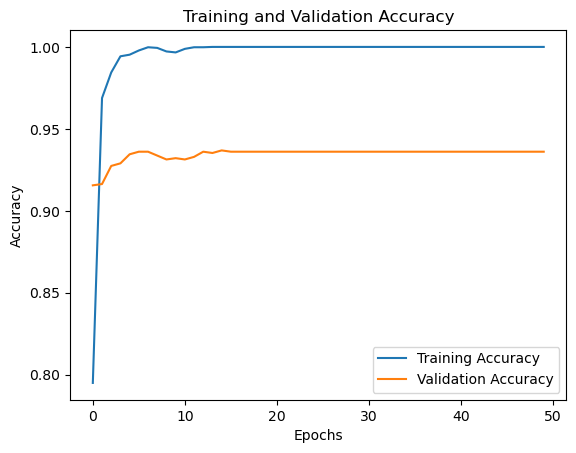

In [66]:
#Plotting Accuracy Across Epochs
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

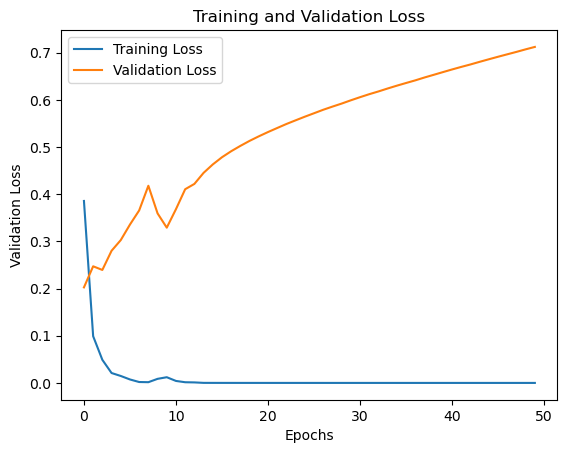

In [67]:
#Plotting Loss Across Epochs
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Validation Loss")
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [68]:
# Collecting Predictions with New Data
y_pred = model.predict(X_test).round()

30/40 [=====================>........] - ETA: 0s

2023-03-05 03:34:59.918587: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


40/40 [==============================] - 0s 4ms/step


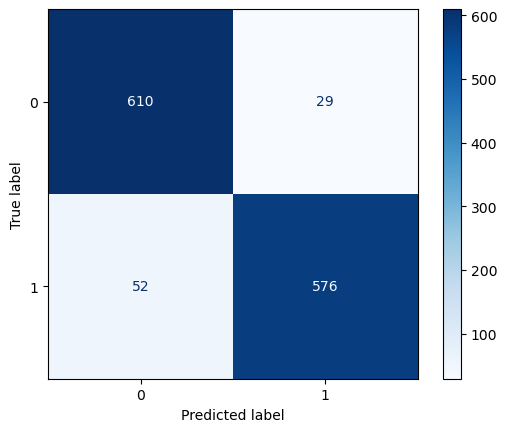

In [69]:
# Plotting Model's Confusion Matrix 
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [70]:
#Getting Classification Report on Model
print(classification_report(y_test, y_pred, target_names=['REAL','FAKE',]))

              precision    recall  f1-score   support

        REAL       0.92      0.95      0.94       639
        FAKE       0.95      0.92      0.93       628

    accuracy                           0.94      1267
   macro avg       0.94      0.94      0.94      1267
weighted avg       0.94      0.94      0.94      1267



In [71]:
#saving all the data and objects
pickle.dump(vectorizer, open('vectorizer.pkl', 'wb'))
pickle.dump(model, open('deepLearningModel.pkl', 'wb'))

INFO:tensorflow:Assets written to: ram://314dad8b-5ed3-431a-9880-8028b224aeb5/assets
